In [1]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D
from keras.layers.core import Dense, Flatten, Masking, Activation
from keras.utils import to_categorical
import keras
from keras.layers import Embedding, GlobalAveragePooling1D, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History


import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#from helper import IOHelper, SequenceHelper

import random
random.seed(1234)

import pandas as pd

import os

import matplotlib.pyplot as plt

import scipy

import seaborn as sns

from itertools import permutations

import logomaker


Using TensorFlow backend.


In [2]:
data = pd.read_csv("fullmodeldata.txt", sep = "\t")
data = data.groupby(np.arange(len(data))//3).mean()

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(data["ratefactor"]).reshape(-1,1))
data["ratefactor"] = scaler.transform(np.array(data["ratefactor"]).reshape(-1,1))

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(data["yieldfactor"]).reshape(-1,1))
data["yieldfactor"] = scaler.transform(np.array(data["yieldfactor"]).reshape(-1,1))

In [10]:
species = data.columns[7:13]
species

Index(['p1', 'p4', 'p7', 'p8', 'p10', 'p13'], dtype='object')

In [11]:
vectors = np.zeros((6,6))
for x in range(6):
    vectors[x][x] = 1

In [12]:
one_hot_encoded_data = []
for y in range(len(data)):
    one_hot_encoded_consortium = []
    for x in range(6):
        if data[species].iloc[y,x] == 1:
            one_hot_encoded_consortium.append(vectors[x])
        else:
            one_hot_encoded_consortium.append([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    one_hot_encoded_data.append(np.array(one_hot_encoded_consortium))

In [13]:
model_data = []
rate_factors = []
yield_factors = []
for x in range(len(one_hot_encoded_data)):
    consortium_permutations = list(permutations(one_hot_encoded_data[x]))
    model_data.append(consortium_permutations)
    for y in range(720):
        rate_factors.append(data["ratefactor"][x])
        yield_factors.append(data["yieldfactor"][x])

model_data = np.array(model_data)

In [14]:
model_data_reshaped = []
for x in range(len(model_data)):
    for y in range(len(model_data[x])):
        model_data_reshaped.append(model_data[x][y])
model_data_reshaped = np.array(model_data_reshaped)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(model_data_reshaped, rate_factors, test_size=0.1, random_state = 4)

# Hyperparameter search to find best model architecture

In [ ]:
r2_list = []
for kernel_length in [1, 2, 3]:
    for conv_filters in [5, 10, 15, 20]:
        for dense_nodes in [20, 30, 40, 60, 80, 100]:
            kernel_length=kernel_length
            conv_filters=conv_filters
            hot_dim=6
            model = Sequential()

            model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], hot_dim), kernel_size=kernel_length))
            model.add(Activation('relu'))
            #model.add(Dropout(0.2))

            #model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
            #model.add(Activation('relu'))
            #model.add(Dropout(0.2))

            #model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
            #model.add(Activation('relu'))
            #model.add(Dropout(0.2))

            model.add(Flatten())
            #model.add(Dense(128, activation="relu"))
            #model.add(Dropout(0.2))
            model.add(Dense(dense_nodes, activation="relu"))
            model.add(Dropout(0.2))
            #model.add(Dense(16, activation="relu"))
            model.add(Dense(1, activation='linear'))

            model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy", "mae", "mse"])

            batch_size=150
            epochs=100

            history=model.fit(x_train, y_train, 
                              batch_size=batch_size, 
                              epochs=epochs, 
                              verbose=1, 
                              validation_split = 0.15, 
                              shuffle=True,
                             callbacks=[EarlyStopping(patience=2 ,restore_best_weights=True),History()])

            predictions=model.predict(x_test)

            r2 = scipy.stats.pearsonr(np.array(y_test).ravel(), predictions.ravel())[0]**2
            r2_list.append([r2, kernel_length, conv_filters, dense_nodes])

In [ ]:
r2_list = pd.DataFrame(r2_list)

In [ ]:
r2_list.sort_values(by=0, ascending = False)

# Test best model (s)

Model with fewest filters for best R^2 tested (kernel length = 1, 10 filters, 100 dense nodes)
Really kernel length should be 1 because convolving a 6x1 over a 6x6 one-hot-encoded matrix is the same as convolving the filter over a 6x1 position weight matrix of the consortium itself

In [16]:
kernel_length=1
conv_filters=10
hot_dim=6
model = Sequential()

model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], hot_dim), kernel_size=kernel_length))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

#model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

#model.add(Conv1D(conv_filters, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Flatten())
#model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy", "mae", "mse"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 10)             70        
_________________________________________________________________
activation_1 (Activation)    (None, 6, 10)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 6,271
Trainable params: 6,271
Non-trainable params: 0
_________________________________________________________________


In [17]:
batch_size=150
epochs=50

history=model.fit(x_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, 
                  verbose=1, 
                  validation_split = 0.15, 
                  shuffle=True,
                 callbacks=[EarlyStopping(patience=2 ,restore_best_weights=True),History()])

Train on 31946 samples, validate on 5638 samples
Epoch 1/50
31946/31946 [==============================] - 2s 63us/step - loss: 0.0264 - acc: 0.0170 - mean_absolute_error: 0.1134 - mean_squared_error: 0.0264 - val_loss: 0.0146 - val_acc: 0.0172 - val_mean_absolute_error: 0.0775 - val_mean_squared_error: 0.0146
Epoch 2/50
31946/31946 [==============================] - 1s 18us/step - loss: 0.0162 - acc: 0.0172 - mean_absolute_error: 0.0864 - mean_squared_error: 0.0162 - val_loss: 0.0130 - val_acc: 0.0172 - val_mean_absolute_error: 0.0769 - val_mean_squared_error: 0.0130
Epoch 3/50
31946/31946 [==============================] - 1s 18us/step - loss: 0.0146 - acc: 0.0176 - mean_absolute_error: 0.0817 - mean_squared_error: 0.0146 - val_loss: 0.0119 - val_acc: 0.0172 - val_mean_absolute_error: 0.0738 - val_mean_squared_error: 0.0119
Epoch 4/50
31946/31946 [==============================] - 1s 17us/step - loss: 0.0131 - acc: 0.0208 - mean_absolute_error: 0.0782 - mean_squared_error: 0.0131 - v

Text(-5.5, 0.95, 'r^2 is 0.978058627389977')

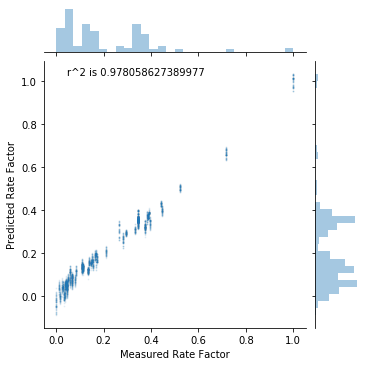

In [18]:
predictions=model.predict(x_test)
r2 = scipy.stats.pearsonr(np.array(y_test).ravel(), predictions.ravel())[0]**2
g = sns.jointplot(np.array(y_test).ravel(), predictions.ravel(),
                  stat_func = None,
                  kind = 'scatter',
                  s = 0.5,
                  alpha = 0.1,
                  height = 5)

g.ax_joint.set_ylabel('Predicted Rate Factor')
g.ax_joint.set_xlabel('Measured Rate Factor')
text="r^2 is "+str(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

In [21]:
wb = model.get_layer("conv1d_1").get_weights()
weights, bias = wb
weights = weights.reshape(1,kernel_length,6,conv_filters)
print(weights.shape)

(1, 1, 6, 10)


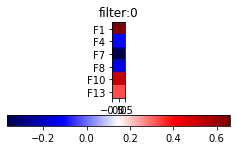

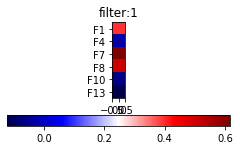

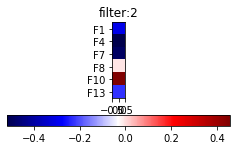

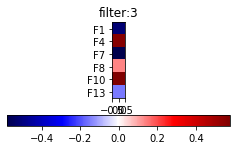

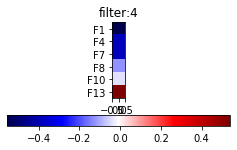

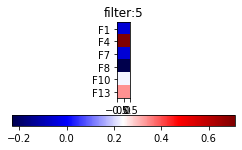

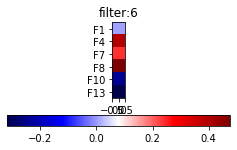

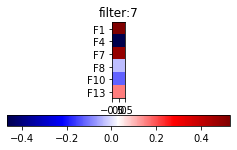

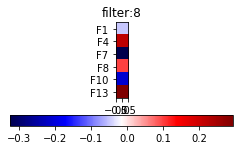

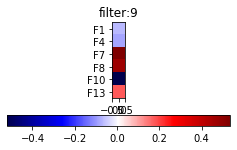

In [22]:
for n in range(conv_filters):
    weight = weights[0,:,:,n]
    transposed_weight = weight.T
    title = "filter:" + str(n)
    plt.figure(figsize=(4,2))
    plt.title(title)
    plt.imshow(transposed_weight,cmap="seismic")
    plt.yticks(range(6),('F1', 'F4', 'F7', 'F8', 'F10', 'F13'))
    plt.colorbar(orientation="horizontal")
    plt.show()

In [23]:
def consortium_logo(data):
    # make Figure and Axes objects
    fig, ax = plt.subplots(1,1,figsize=[2,4])

    # create color scheme
    color_scheme ={'B': 'orange', 
                    'L': 'red', 
                    'A': 'blue', 
                    'P': 'darkgreen',
                    'E': 'black',
                    'S': 'brown'}

    # create Logo object
    logo_logo = logomaker.Logo(data,
                               ax=ax,
                               color_scheme=color_scheme,
                               baseline_width=0,
                               font_name='Arial',
                               show_spines=False,
                               vsep=.005,
                               width=.95,
                              fade_below = 0.8)


    logo_logo.style_glyphs_below(font_name='OCR A Std', flip=True, width=1.0)

    # remove tick marks
    ax.set_xticks([])
    # tighten layout

    logo_logo.fig.tight_layout()

# Convolve filters over data to elucidate meaning

In [24]:
filters = []
for x in range(conv_filters):
    filters.append(weights[0,:,:,x])
    
test = pd.DataFrame(np.array(filters).reshape(conv_filters,6))
test.columns = ["B", "L", "A", "P", "E", "S"]

In [25]:
convolution_data = []
for z in range(len(filters)):
    total_conv = []
    for y in range(len(one_hot_encoded_data)):
        single_conv = []
        sequence = one_hot_encoded_data[y]
        for x in range(6-kernel_length+1):
            b = sequence[x:x+kernel_length]
            single_conv.append(np.sum(b*filters[z]))
        total_conv.append(np.sum(single_conv))
    convolution_data.append(total_conv)

In [26]:
filter_names = []
for x in range(len(filters)):
    filter_names.append("filter "+str(x))
convolution_data = pd.DataFrame(np.array(convolution_data)).T
convolution_data.columns = [filter_names]

In [27]:
merged_data = pd.concat([data, convolution_data], axis=1, sort=False).sort_values(by="ratefactor", ascending = False).reset_index()
filter_names = merged_data.columns[13:-1]

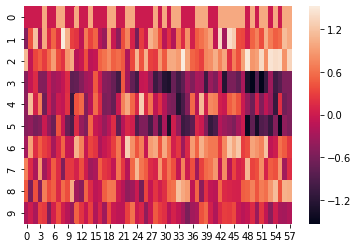

In [33]:
sns.heatmap(np.array(merged_data[filter_names]).T)
conv_correlations = []
for x in range(len(filters)):
    conv_correlations.append(scipy.stats.pearsonr((merged_data["ratefactor"]), merged_data[filter_names[x]])[0])


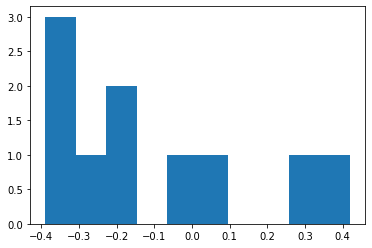

,0
3,0.418658
5,0.291679
4,0.056320
9,-0.007926
7,-0.158514
8,-0.213833
1,-0.237525
0,-0.314846
6,-0.358941
2,-0.388714


In [34]:
plt.hist(conv_correlations, bins = len(conv_correlations))
plt.show()
pd.DataFrame(conv_correlations).sort_values(by = 0, ascending=False)

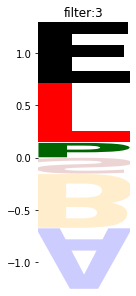

In [35]:
for x in [3]:
    consortium_logo(pd.DataFrame(test.iloc[x]).T)
    title = "filter:" + str(x)
    plt.title(title)

# Attempting to make predictions

In [36]:
x_train, x_test, y_train, y_test = train_test_split(np.array(one_hot_encoded_data), data["ratefactor"], test_size=0.15, random_state = 4)

In [37]:

x_train_model_data = []
y_train_data = []
for x in range(len(x_train)):
    consortium_permutations = list(permutations(x_train[x]))
    x_train_model_data.append(consortium_permutations)
    for y in range(720):
        y_train_data.append(y_train.iloc[x])

y_train = y_train_data
x_train_model_data = np.array(x_train_model_data)

model_predict_data_reshaped = []
for x in range(len(x_train_model_data)):
    for y in range(len(x_train_model_data[x])):
        model_predict_data_reshaped.append(x_train_model_data[x][y])
model_predict_data_reshaped = np.array(model_predict_data_reshaped)

x_train = model_predict_data_reshaped


x_test_model_data = []
y_test_data = []
for x in range(len(x_test)):
    consortium_permutations = list(permutations(x_test[x]))
    x_test_model_data.append(consortium_permutations)
    for y in range(720):
        y_test_data.append(y_test.iloc[x])

y_test = y_test_data
x_test_model_data = np.array(x_test_model_data)

model_test_data_reshaped = []
for x in range(len(x_test_model_data)):
    for y in range(len(x_test_model_data[x])):
        model_test_data_reshaped.append(x_test_model_data[x][y])
model_test_data_reshaped = np.array(model_test_data_reshaped)

x_test = model_test_data_reshaped

In [38]:
kernel_length=3
conv_layers=20
hot_dim=6
model = Sequential()

model.add(Conv1D(conv_layers, padding='same', input_shape=(x_train.shape[1], hot_dim), kernel_size=kernel_length))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(conv_layers, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(conv_layers, padding='same', input_shape=(x_train.shape[1], 1), kernel_size=kernel_length))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())
#model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy", "mae", "mse"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 6, 20)             380       
_________________________________________________________________
activation_2 (Activation)    (None, 6, 20)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 20)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 20)             1220      
_________________________________________________________________
activation_3 (Activation)    (None, 6, 20)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 20)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 20)             1220      
__________

In [ ]:
batch_size=50
epochs=30

history=model.fit(x_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, 
                  verbose=1, 
                  validation_split = 0.15, 
                  shuffle=True,
                 callbacks=[EarlyStopping(patience=3 ,restore_best_weights=True),History()])

Text(-5.5, 0.95, 'r^2 is 0.4360458421766842')

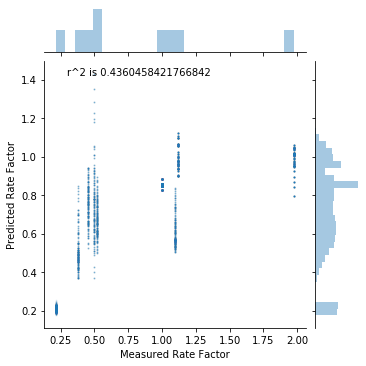

In [378]:
predictions=model.predict(x_test)
r2 = scipy.stats.pearsonr(np.array(y_test).ravel(), predictions.ravel())[0]**2
g = sns.jointplot(np.array(y_test).ravel(), predictions.ravel(),
                  stat_func = None,
                  kind = 'scatter',
                  s = 0.5,
                  alpha = 0.1,
                  height = 5)

g.ax_joint.set_ylabel('Predicted Rate Factor')
g.ax_joint.set_xlabel('Measured Rate Factor')
text="r^2 is "+str(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')